## Análisis y Tratamiento de Imágenes Satelitales

## TP3

In [1012]:
import cv2
import rasterio
from rasterio import plot
import numpy as np
from scipy.ndimage import convolve
import matplotlib.pyplot as plt

### 1) Implementar los siguientes algoritmos de umbralización y aplicarlos a una imagen de grises o color, según corresponda.

La umbralización (en inglés thresholding) es una técnica de segmentación de imágenes que consiste en separar regiones de interés en una imagen, asignando valores binarios o múltiples clases a los píxeles según su intensidad.

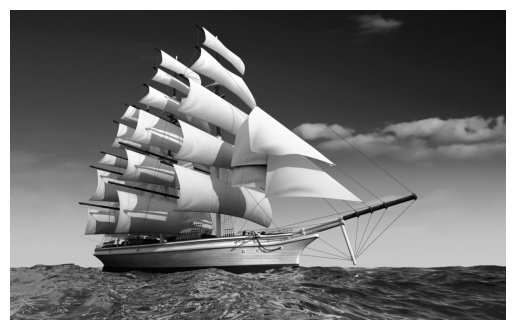

In [1013]:
# Como primer paso se selecciona una imagen

img = cv2.imread("C:/Users/arnic/Desktop/Ariel/MCD/13 - A y T de Imagenes satelitales/Images/ship.jpg", cv2.IMREAD_GRAYSCALE)

# Así entonces, se puede desplegar la imagen seleccionada
plt.imshow(img, cmap='gray')
plt.axis('off')  # Opcional: Oculta los ejes
plt.show()

a) Umbralización iterativa

El primer método automático de selección de umbrales fue probablemente el algoritmo de ISODATA (Iterative Self-Organizing Data Analysis Technique), que fue propuesto originalmente por Ridler y Calvard (1978). En el algoritmo, primero se determina un umbral inicial (en la mayoría de los casos se selecciona por el valor de intensidad promedio de la imagen) y luego se usa para segmentar el histograma en dos clases, es decir, A y B. Los valores medios de intensidad, $m_A$ y $m_B$, para ambas clases y, a continuación, se determina el nuevo umbral como la media de $m_A$ y $m_B$. El nuevo umbral se actualiza de forma iterativa mediante los nuevos valores de intensidad media hasta que se alcanza la convergencia.

In [1014]:
# Se define la función que permita realizar la Umbralización iterativa:

def umbral_isodata(imagen, epsilon=0.5):
    """
    Umbralización automática iterativa (IsoData).
    
    epsilon: es un parámetro de tolerancia que controla cuándo detener la iteración
             y controla la precisión de la convergencia del umbral.
    """
    T = np.mean(imagen)
    delta = 2 * epsilon # Se inicializa grande (2 * epsilon) para garantizar que el bucle while comience.

    while delta >= epsilon:
        G1 = imagen[imagen < T]
        G2 = imagen[imagen >= T]
        if len(G1) == 0 or len(G2) == 0:      # Si algún grupo queda vacío (no hay píxeles),
            break                             # se interrumpe el bucle para evitar divisiones por cero.
        mu1 = np.mean(G1)
        mu2 = np.mean(G2)
        T_new = (mu1 + mu2) / 2
        delta = abs(T - T_new)
        T = T_new

    _, binaria = cv2.threshold(imagen, T, 255, cv2.THRESH_BINARY)
    return binaria, T

In [1015]:
# Se aplica la umbralización 

resultado, umbral = umbral_isodata(img)

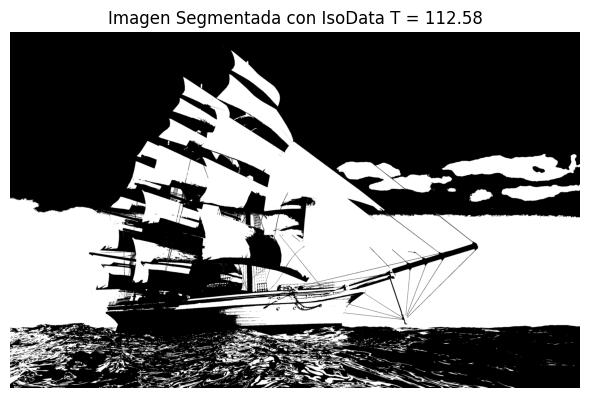

In [1016]:
# Se muestra la imagen final umbralizada
plt.figure(figsize=(6, 6))
plt.imshow(resultado, cmap='gray')
plt.title(f"Imagen Segmentada con IsoData T = {umbral:.2f}")
plt.axis("off")

plt.tight_layout()
plt.show()

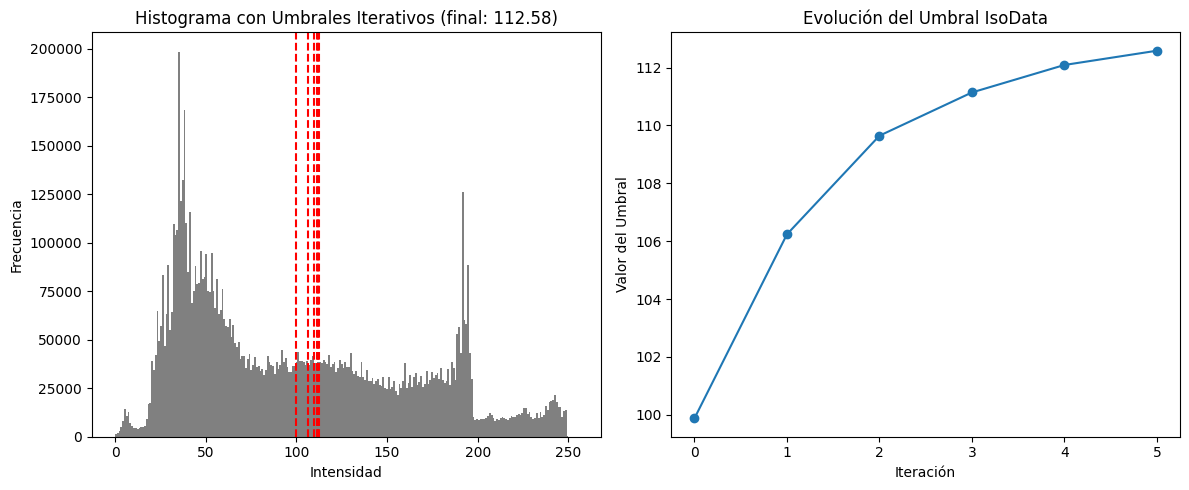

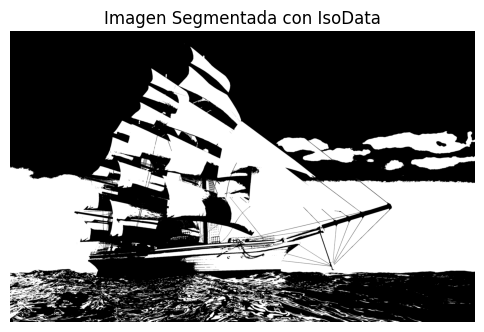

In [1017]:
# Para entender mejor este algoritmo, es posible observar cómo se realiza la iteración y se obtienen los umbrales 
# intermedios:

def isodata_iterativo(imagen, epsilon=0.5):
    """
    Método IsoData con seguimiento de umbrales intermedios.
    Devuelve la imagen umbralizada, umbral final y lista de todos los umbrales.
    """
    T = np.mean(imagen)
    delta = 2 * epsilon
    umbrales = [T]

    while delta >= epsilon:
        G1 = imagen[imagen < T]
        G2 = imagen[imagen >= T]
        if len(G1) == 0 or len(G2) == 0:
            break
        mu1 = np.mean(G1)
        mu2 = np.mean(G2)
        T_new = (mu1 + mu2) / 2
        delta = abs(T - T_new)
        T = T_new
        umbrales.append(T)

    _, binaria = cv2.threshold(imagen, T, 255, cv2.THRESH_BINARY)
    return binaria, T, umbrales

# Se ejecuta IsoData
binaria, umbral_final, umbrales = isodata_iterativo(img)

# Se muestra el histograma y evolución del umbral

plt.figure(figsize=(12, 5))

# Histograma de intensidades
plt.subplot(1, 2, 1)
plt.hist(img.ravel(), bins=256, range=(0, 255), color='gray')
for t in umbrales:
    plt.axvline(t, color='red', linestyle='--')
plt.title(f"Histograma con Umbrales Iterativos (final: {umbral_final:.2f})")
plt.xlabel("Intensidad")
plt.ylabel("Frecuencia")

# Evolución del umbral paso a paso
plt.subplot(1, 2, 2)
plt.plot(umbrales, marker='o', linestyle='-')
plt.title("Evolución del Umbral IsoData")
plt.xlabel("Iteración")
plt.ylabel("Valor del Umbral")

plt.tight_layout()
plt.show()

# Imagen final umbralizada
plt.figure(figsize=(6, 6))
plt.imshow(binaria, cmap='gray')
plt.title("Imagen Segmentada con IsoData")
plt.axis("off")
plt.show()

In [ ]:
# En estos gráficos se puede observar como el algortimo ISODATA va realizando las iteraciones y obteniendo los valores de umbrales intermedios,
# hasta llegar a la 5ta iteraciones y obtener el umbral final de 112,58.

b) Método de Umbralización de Otsu.

El método de Umbralización de Otsu (Nobuyuki Otsu, 1979) es un algoritmo no iterativo que calcula automáticamente el umbral óptimo para segmentar una imagen en dos clases (por ejemplo: fondo y objeto).

In [1018]:
# Se define la función que permita emplear el método Otsu:

def umbral_otsu(imagen):
    """
    Umbralización automática mediante método Otsu.
    """
    # Se aplica umbralización de Otsu
    _, otsu_binaria = cv2.threshold(imagen, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    return  _,otsu_binaria

In [1019]:
# Se aplica la función del método Otsu:

_,img_otsu = umbral_otsu(img)

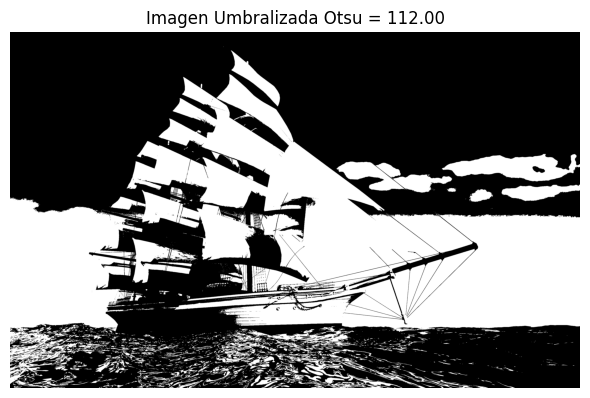

In [1021]:
# Se muestra la imagen umbralizada

plt.figure(figsize=(6, 6))
plt.imshow(img_otsu, cmap='gray')
plt.title(f"Imagen Umbralizada Otsu = {_:.2f}")
plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Se observa que el método Otsu obtiene prácticamente el mismo umbral que el método ISODATA.

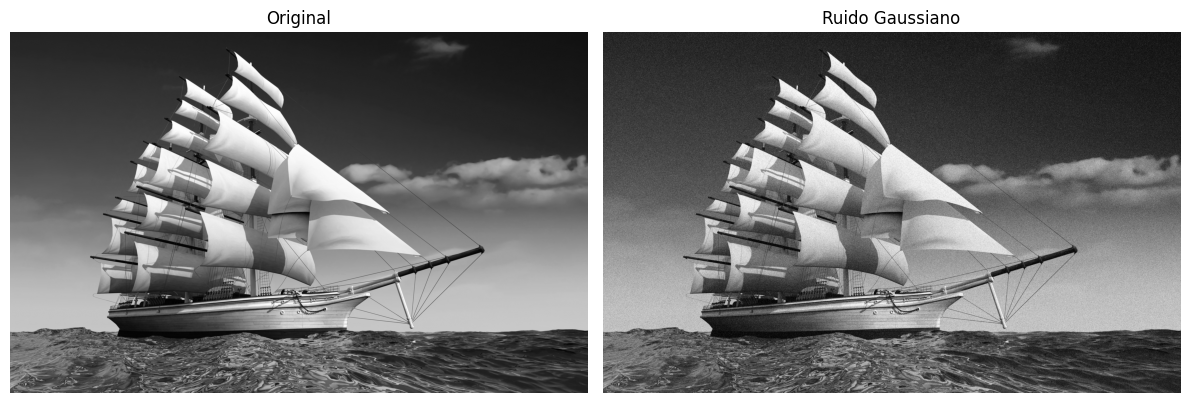

In [1023]:
# Con el propósito de analizar mejor la diferencia en la aplicación de ambos métodos, se contamina la imagen original con ruido para luego implementar los métodos:

# En este caso, se pretende añadir ruido aditivo, definiendo al función que permite agregar ruido gaussiano:

def agregar_ruido_gaussiano(imagen, porcentaje, media=0, desvio=20):
    """
    Agrega ruido Gaussiano aditivo a un porcentaje de los píxeles de la imagen.
    
    Args:
        imagen: imagen en escala de grises (2D).
        porcentaje: porcentaje de píxeles a contaminar (0–100).
        media: media del ruido.
        desvio: desviación estándar del ruido.
        
    Returns:
        Imagen con ruido gaussiano agregado.
    """
    imagen = imagen.astype(np.float32)
    total_pixeles = imagen.shape[0] * imagen.shape[1]
    n_ruido = int(total_pixeles * (porcentaje / 100))
    
    indices = np.random.choice(total_pixeles, n_ruido, replace=False)
    
    ruido = np.random.normal(media, desvio, size=n_ruido)  
        
    flat = imagen.flatten()
    
    flat[indices] += ruido
    
    flat = np.clip(flat, 0, 255)

    return flat.reshape(imagen.shape).astype(np.uint8)

# Se aplica el ruido aditivo
imagen_r = agregar_ruido_gaussiano(img, 40, media=0, desvio=50)

# Ahora se comparan los resultados con la imagen original
def mostrar(imagenes, titulos):
    plt.figure(figsize=(12, 6))
    for i, (img, title) in enumerate(zip(imagenes, titulos), 1):
        plt.subplot(1, len(imagenes), i)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

mostrar([img, imagen_r],
        ["Original", "Ruido Gaussiano"])

In [1024]:
# Se aplica entonces, los métodos de umbralización a la imagen contaminada

resultado_r, umbral_r = umbral_isodata(imagen_r)

_r,img_otsu_r = umbral_otsu(imagen_r)

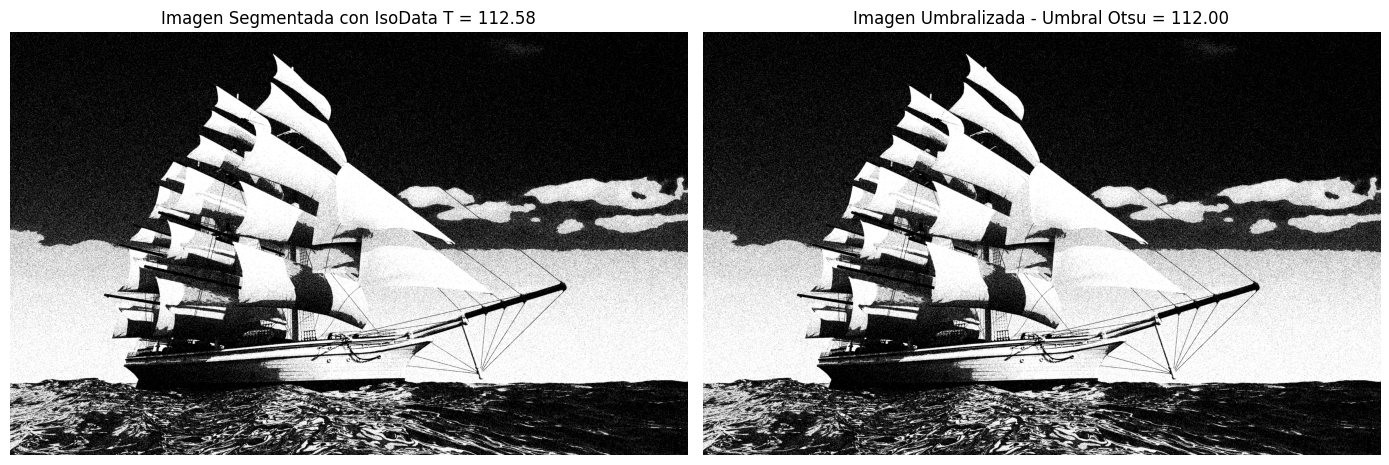

In [1025]:
# Comparamos los resultados:

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.imshow(resultado_r, cmap='gray')
plt.title(f"Imagen Segmentada con IsoData T = {umbral_r:.2f}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_otsu_r, cmap='gray')
plt.title(f"Imagen Umbralizada - Umbral Otsu = {_r:.2f}")
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Luego de aplicar ruido gaussiano a la imagen original e implementar los métodos de umbralización, se observa que ambos continuan llegando
# practicamente al mismo resultado.

C:\Users\arnic\AppData\Local\Temp\ipykernel_12120\1896370620.py:21: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.10; the parameter will become keyword-only in 3.12.
  plt.subplot(122), plt.hist(image_noisy.ravel(), 256, [0, 256]), plt.title('Histograma')


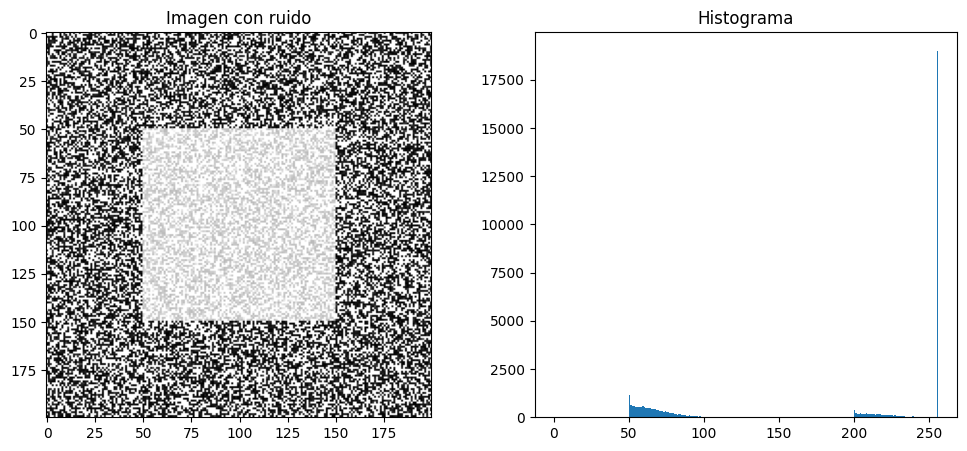

In [1026]:
# Se decide seleccionar una imagen mas simple, en escala de grises, con intensidad solapada:

from skimage.filters import threshold_otsu, threshold_isodata

# Se crea una imagen sintética (200x200)
image = np.zeros((200, 200), dtype=np.uint8)

# Con fondo oscuro (valor 50)
image[:, :] = 50  

# Y con en objeto rectangular claro (valor 200)
image[50:150, 50:150] = 200  

# Se añade ruido aleatorio para complicar el histograma
noise = np.random.normal(0, 20, (200, 200)).astype(np.uint8)
image_noisy = cv2.add(image, noise)

# Se muestra la imagen y su histograma
plt.figure(figsize=(12, 5))
plt.subplot(121), plt.imshow(image_noisy, cmap='gray'), plt.title('Imagen con ruido')
plt.subplot(122), plt.hist(image_noisy.ravel(), 256, [0, 256]), plt.title('Histograma')
plt.show()

In [1027]:
# Se procede entonces a aplicar ambos los métodos de umbralización a la nueva imagen seleccionada:

resultado_c, umbral_c = umbral_isodata(image_noisy)

_c,img_otsu_c = umbral_otsu(image_noisy)

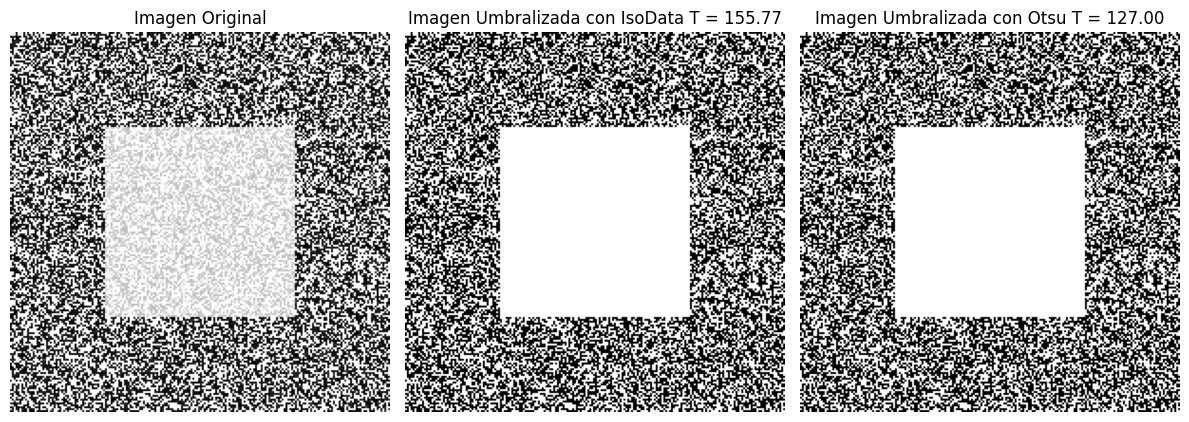

In [1028]:
# Se comparan los resultados:

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(image_noisy, cmap='gray')
plt.title(f"Imagen Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(resultado_c, cmap='gray')
plt.title(f"Imagen Umbralizada con IsoData T = {umbral_c:.2f}")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_otsu_c, cmap='gray')
plt.title(f"Imagen Umbralizada con Otsu T = {_c:.2f}")
plt.axis('off')
plt.tight_layout()
plt.show()

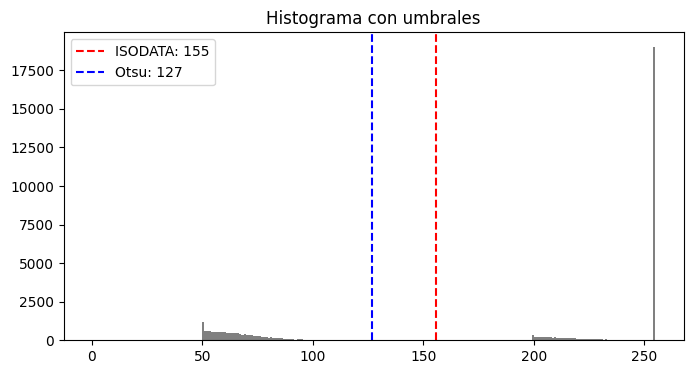

In [1029]:
# Se observa el histograma

plt.figure(figsize=(8, 4))
plt.hist(image_noisy.ravel(), bins=256, range=(0, 255), color='gray')
plt.axvline(umbral_c, color='r', linestyle='--', label=f'ISODATA: {int(umbral_c)}')
plt.axvline(_c, color='b', linestyle='--', label=f'Otsu: {int(_c)}')
plt.title('Histograma con umbrales')
plt.legend()
plt.show()

In [ ]:
# Se observa que los métodos de umbralización obtienen valores diferentes.
# De estos ejemplos se puede concluir que cuando existe una asimetría en el tamaño de las clases a segmentar y una posible diferencia en sus dispersiones de intensidad (el 
# fondo grande puede tener más variación que el objeto central, o viceversa), el umbral que maximiza la varianza entre clases (Otsu) puede no ser exactamente el mismo 
# que el umbral que se encuentra a medio camino entre las medias de las clases finales (ISODATA).
# Esto se debe a que el método ISODATA converge a un umbral cercano al punto medio de las medias de objeto y fondo, mientras que Otsu, al considerar el gran tamaño del fondo 
# y buscar maximizar la varianza, podría encontrar que el punto óptimo para separar las distribuciones está ligeramente desplazado respecto al punto medio de las medias.

c) Clasificar una imagen RGB en 8 (o menos) colores, utilizando el método de umbralización banda por banda.

Para utilizar el método de Otsu para umbralizar banda por banda en una imagen RGB, cada canal se divide en 2 clases:
 - Baja intensidad
 - Alta intensidad

Enteonces, si cada canal se binariza se obtiene:
 - Canal R: 2 valores → {0, 1}
 - Canal G: 2 valores → {0, 1}
 - Canal B: 2 valores → {0, 1}

El espacio resultante es: 2 x 2 x 2 = 8 combinaciones, y la la imagen queda cuantizada en 8 colores básicos.

In [1030]:
# Se lee la imagen RGB

imagen_bgr = cv2.imread("C:/Users/arnic/Desktop/Ariel/MCD/13 - A y T de Imagenes satelitales/Images/fruits3.jpg")
imagen_rgb = cv2.cvtColor(imagen_bgr, cv2.COLOR_BGR2RGB)

In [1031]:
# Se dividen los canales

r, g, b = cv2.split(imagen_rgb)

In [1032]:
# Se umbraliza cada canal con Otsu

_, r_bin = cv2.threshold(r, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
_, g_bin = cv2.threshold(g, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
_, b_bin = cv2.threshold(b, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

In [1033]:
# Se construye un índice combinando los 3 bits → 0 a 7
indices = (r_bin << 2) | (g_bin << 1) | b_bin

# Se define la paleta de 8 colores básicos 
paleta = np.array([
    [0, 0, 0],       # 000
    [0, 0, 255],     # 001
    [0, 255, 0],     # 010
    [0, 255, 255],   # 011
    [255, 0, 0],     # 100
    [255, 0, 255],   # 101
    [255, 255, 0],   # 110
    [255, 255, 255]  # 111
], dtype=np.uint8)

# Se construye la imagen cuantizada
h, w = indices.shape
imagen_cuantizada = paleta[indices.ravel()].reshape((h, w, 3))

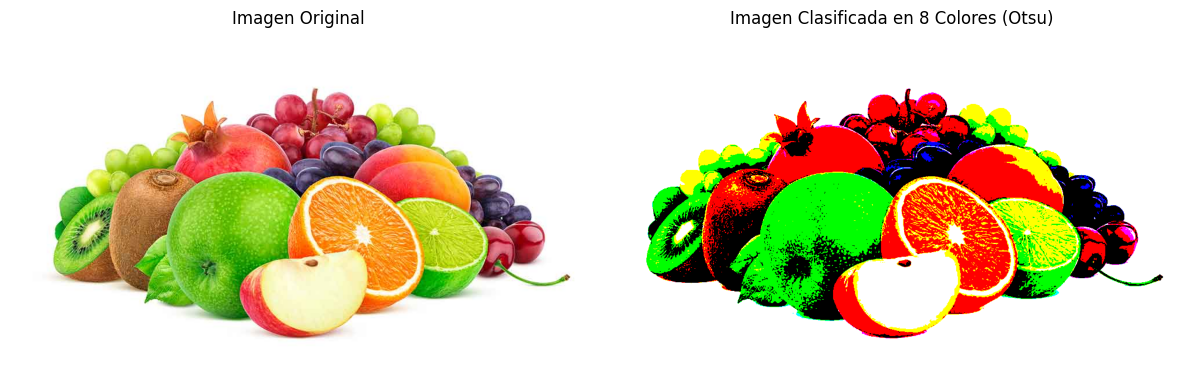

In [1034]:
# Se muestran los resultados
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(imagen_rgb)
plt.title("Imagen Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(imagen_cuantizada)
plt.title("Imagen Clasificada en 8 Colores (Otsu)")
plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# En este ejemplo se puede observar como el método Otsu umbraliza perfectamente los objetos de diferentes colores bien definidos.

### 2) Implementar el detector de borde de Canny y aplicarlo a una imagen utilizando diferentes parámetros.

El detector de bordes de Canny (John Canny, 1986) es un algoritmo multi-etapa diseñado para encontrar bordes óptimos en imágenes. Su objetivo es detectar bordes finos, continuos y bien localizados, minimizando ruido y falsas detecciones

In [1038]:
# Como primer paso se selecciona una imagen

apple = cv2.imread("C:/Users/arnic/Desktop/Ariel/MCD/13 - A y T de Imagenes satelitales/Images/apple.jpeg", cv2.IMREAD_GRAYSCALE)

# Se aplica un suavizado Gaussiano, recomendado al momento de utilizar Canny:
imagen_suavizada = cv2.GaussianBlur(apple, (5, 5), 1.4)

# Se definen diferentes pares de umbrales
parametros = [
    (50, 100),
    (50, 150),
    (100, 200),
    (150, 250),
    (50, 250)
]

# Se aplica Canny con cada par de umbrales
bordes = []
for t1, t2 in parametros:
    edges = cv2.Canny(imagen_suavizada, threshold1=t1, threshold2=t2)
    bordes.append((t1, t2, edges))

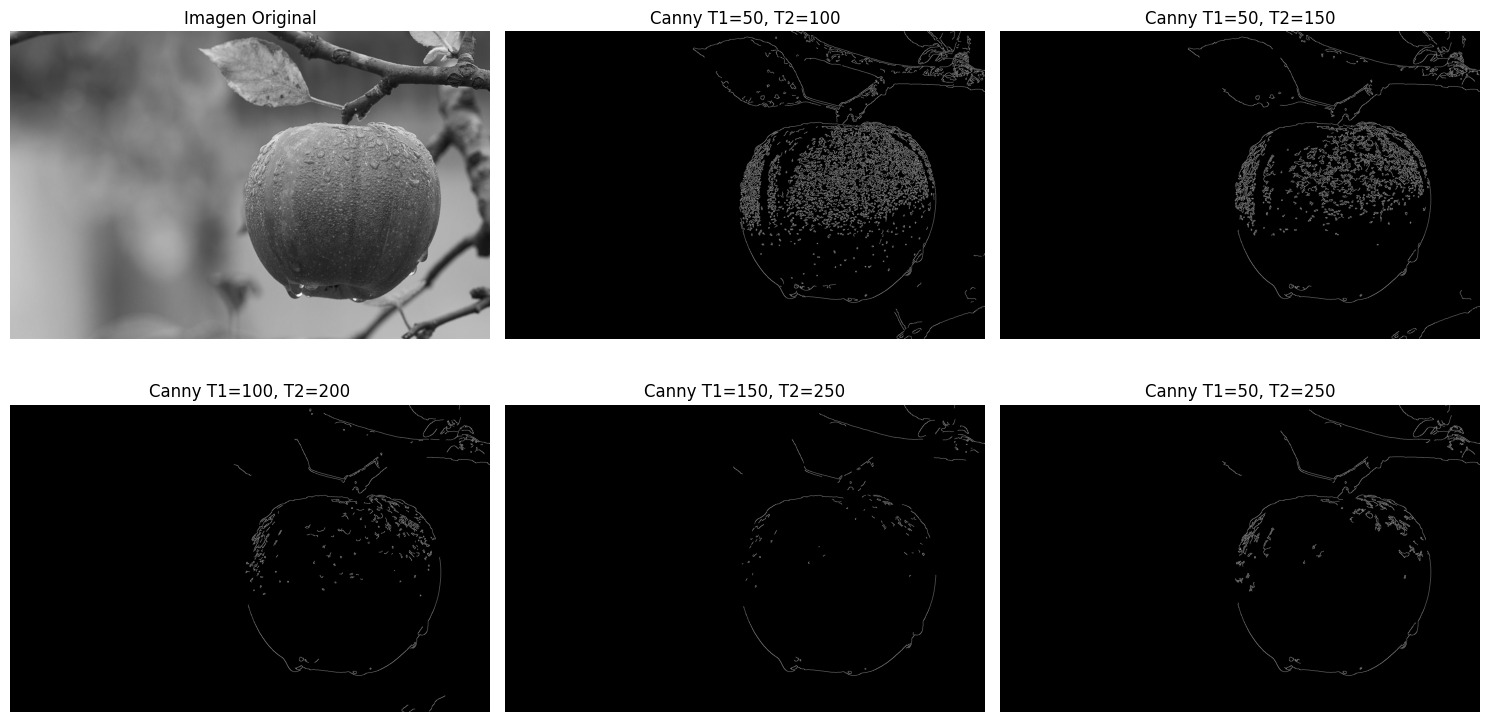

In [1040]:
# Se comparan los resultados en una cuadrícula
plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1)
plt.imshow(apple, cmap='gray')
plt.title("Imagen Original")
plt.axis("off")

for i, (t1, t2, edges) in enumerate(bordes):
    plt.subplot(2, 3, i + 2)
    plt.imshow(edges, cmap='gray')
    plt.title(f"Canny T1={t1}, T2={t2}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# En estas imágenes resultantes se puede comparar y observar cómo cambian los bordes al variar los umbrales. Cuando se seleccionan umbrales bajos, aumenta 
# la detección de bordes pero hay mas ruido. Cuando se seleccionan umbrales altos, el ruido disminuye pero se aumenta el riesgo de perder bordes finos.

### 3) Implementar el Método del Smallest Univaluate Assimilating Nucleus (SUSAN) para bordes y esquinas. Aplicarlo a una imagen y a sus versiones contaminadas. Analizar los resultados.

In [1041]:
# Se leee la imagen seleccionada y se obtienen sus versiones contaminadas con ruido gaussiano, exponencial e impulsivo (sal y pimienta).

img2 = cv2.imread("C:/Users/arnic/Desktop/Ariel/MCD/13 - A y T de Imagenes satelitales/Images/edificio.jpg", cv2.IMREAD_GRAYSCALE)

def agregar_ruido_exponencial(imagen, porcentaje, lamda=1.5):
    """
    Agrega ruido Exponencial multiplicativo a un porcentaje de los píxeles.
    
    Args:
        imagen: imagen en escala de grises (2D).
        porcentaje: porcentaje de píxeles a contaminar (0–100).
        lamda: parámetro lambda del ruido exponencial.
        
    Returns:
        Imagen con ruido exponencial multiplicativo agregado.
    """
    imagen = imagen.astype(np.float32)
    total_pixeles = imagen.shape[0] * imagen.shape[1]
    n_ruido = int(total_pixeles * (porcentaje / 100))
    
    indices = np.random.choice(total_pixeles, n_ruido, replace=False)
    
    ruido = np.random.exponential(scale=1/lamda, size=n_ruido)
    ruido = ruido / np.mean(ruido)

    flat = imagen.flatten()
    flat[indices] *= ruido
    
    flat = np.clip(flat, 0, 255)

    return flat.reshape(imagen.shape).astype(np.uint8)

def agregar_ruido_sal_pimienta(imagen, porcentaje):
    """
    Aplica ruido Sal y Pimienta a un porcentaje de píxeles de una imagen.

    Args:
        imagen: imagen de entrada.
        porcentaje: porcentaje de píxeles a contaminar (0–100).

    Returns:
        Imagen con ruido sal y pimienta.
    """
    imagen = imagen.copy()
    total_pixeles = imagen.shape[0] * imagen.shape[1]
    num_ruido = int(total_pixeles * porcentaje / 100)

    # Coordenadas aleatorias para sal y pimienta
    coords = np.random.choice(total_pixeles, size=num_ruido, replace=False)
    coords = np.unravel_index(coords, (imagen.shape[0], imagen.shape[1]))

    # Separar en mitad para sal y mitad para pimienta
    mitad = num_ruido // 2
    sal_coords = (coords[0][:mitad], coords[1][:mitad])
    pimienta_coords = (coords[0][mitad:], coords[1][mitad:])

    # Aplicar ruido
    imagen[sal_coords] = [255]       # Sal (blanco)
    imagen[pimienta_coords] = [0]    # Pimienta (negro)

    return imagen

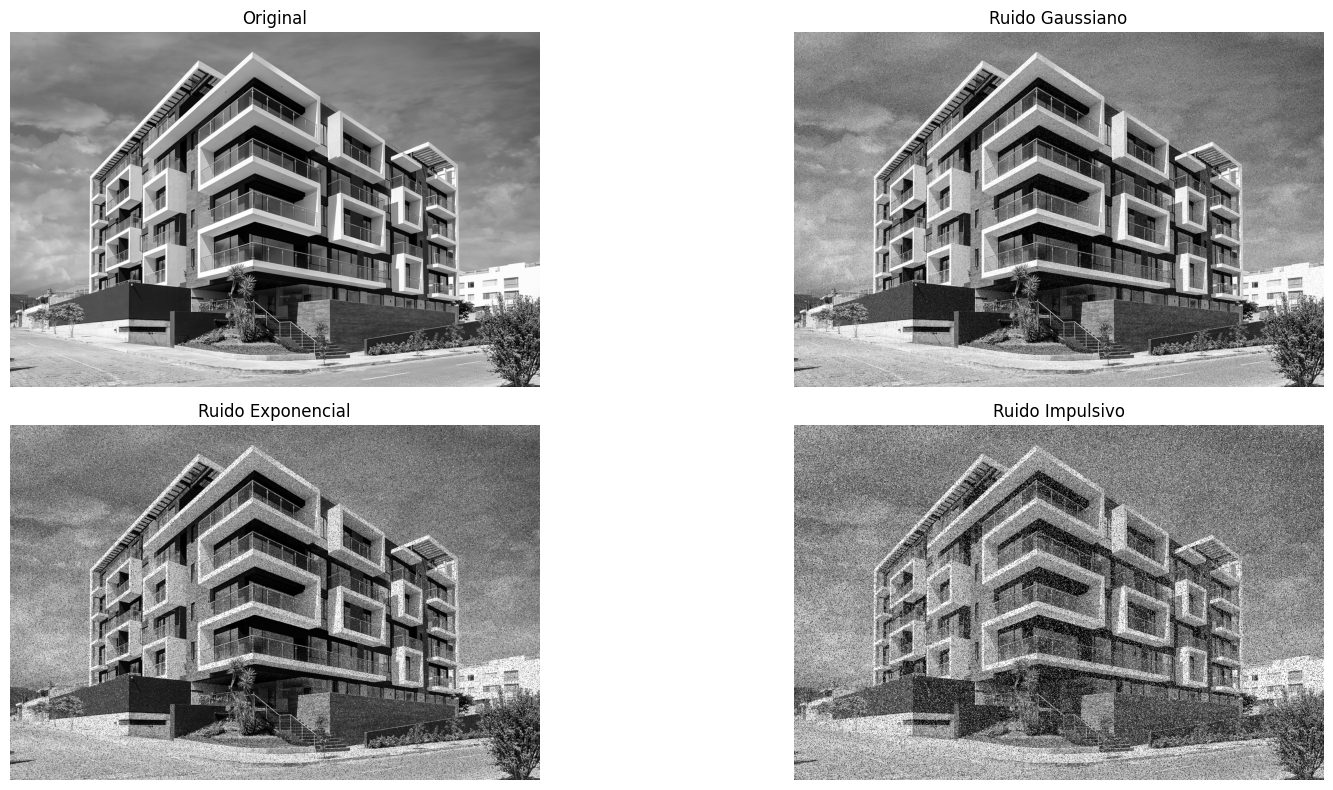

In [1042]:
# Se aplican los ruidos

taj_g = agregar_ruido_gaussiano(img2, 30, media=0, desvio=40)
taj_e = agregar_ruido_exponencial(img2, 25, lamda=1.5)
taj_i = agregar_ruido_sal_pimienta(img2, 25)

# Así entonces, se puede desplegar la imagen seleccionada y sus versiones contaminadas

def mostrar(imagenes, titulos):
    plt.figure(figsize=(18, 8))
    for i, (img, title) in enumerate(zip(imagenes, titulos), 1):
        plt.subplot(2, 2, i)
        plt.imshow(cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE))
        plt.title(title)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

mostrar([img2, taj_g, taj_e, taj_i],
        ["Original", "Ruido Gaussiano", "Ruido Exponencial", "Ruido Impulsivo"])

a) Detección de bordes.

SUSAN es un algoritmo para detección de bordes y esquinas que no usa derivadas ni convoluciones clásicas. 

In [1043]:
# Se define la función que permita detectar bordes con SUSAN:

def susan_bordes(imagen_gray, mascara_radio=3, t_similitud=20):
    """
    Detector SUSAN solo para bordes.
    
    Args:
        imagen_gray: imagen en escala de grises.
        mascara_radio: radio de la máscara circular.
        t_similitud: umbral de similitud de intensidad.
        
    Returns:
        Imagen binaria de bordes detectados.
    """
    imagen = imagen_gray.astype(np.float32)
    altura, ancho = imagen.shape
    
    # Máscara circular
    y, x = np.ogrid[-mascara_radio:mascara_radio+1, -mascara_radio:mascara_radio+1]
    mascara = x**2 + y**2 <= mascara_radio**2
    vecinos = np.argwhere(mascara)
    usan_max = vecinos.shape[0]

    salida = np.zeros_like(imagen, dtype=np.uint8)
    
    for i in range(mascara_radio, altura - mascara_radio):
        for j in range(mascara_radio, ancho - mascara_radio):
            nucleo = imagen[i, j]
            usan = 0
            for dy, dx in vecinos:
                yv = i + dy - mascara_radio
                xv = j + dx - mascara_radio
                if np.abs(imagen[yv, xv] - nucleo) < t_similitud:
                    usan += 1
            respuesta = usan_max - usan
            
            # Criterio: solo BORDES → USAN pequeño pero no mínimo
            if respuesta > usan_max * 0.4 and respuesta < usan_max * 0.75:
                salida[i, j] = 255
                
    return salida

In [1044]:
# Se aplica el método SUSAN a cada imagen

bsusan_o = susan_bordes(img2, mascara_radio=3, t_similitud=20)
bsusan_g = susan_bordes(taj_g, mascara_radio=3, t_similitud=20)
bsusan_e = susan_bordes(taj_e, mascara_radio=3, t_similitud=20)
bsusan_i = susan_bordes(taj_i, mascara_radio=3, t_similitud=20)


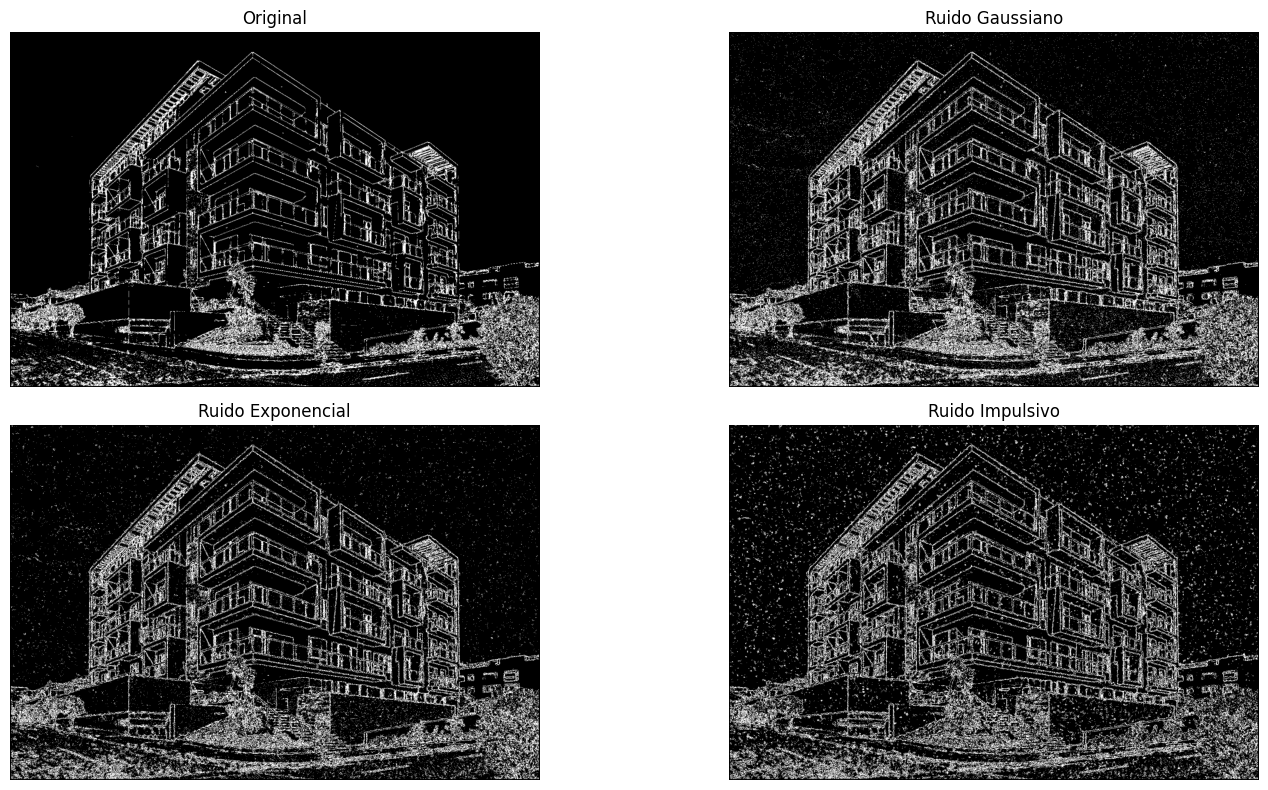

In [1045]:
# Se muestran los resultados para la imagen seleccionada y sus versiones contaminadas

def mostrar(imagenes, titulos):
    plt.figure(figsize=(16, 8))
    for i, (img, title) in enumerate(zip(imagenes, titulos), 1):
        plt.subplot(2, 2, i)
        plt.imshow(cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE))
        plt.title(title)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

mostrar([bsusan_o, bsusan_g, bsusan_e, bsusan_i],
        ["Original", "Ruido Gaussiano", "Ruido Exponencial", "Ruido Impulsivo"])

In [ ]:
# Como se observa en las imágenes resultantes, al aplicar el detector de SUSAN para bordes sobre la imagen original, se detectan contornos bien definidos, líneas
# finas y continuas. Sin embargo, en las imágenes contaminadas, el ruido rompe las regiones homogéneas y el detector muestra falsos bordes débiles y dispersos, 
# que se asentúan en el ruido impulsivo. 

b) Detección de esquinas.

In [1046]:
# Se define la función que permita detectar esquinas con SUSAN:

def susan_esquinas(imagen_gray, mascara_radio=3, t_similitud=20):
    """
    Detector SUSAN solo para esquinas.
    
    Args:
        imagen_gray: imagen en escala de grises.
        mascara_radio: radio de la máscara circular.
        t_similitud: umbral de similitud de intensidad.
        
    Returns:
        Imagen binaria de esquinas detectadas.
    """
    imagen = imagen_gray.astype(np.float32)
    altura, ancho = imagen.shape
    
    # Máscara circular
    y, x = np.ogrid[-mascara_radio:mascara_radio+1, -mascara_radio:mascara_radio+1]
    mascara = x**2 + y**2 <= mascara_radio**2
    vecinos = np.argwhere(mascara)
    usan_max = vecinos.shape[0]

    salida = np.zeros_like(imagen, dtype=np.uint8)
    
    for i in range(mascara_radio, altura - mascara_radio):
        for j in range(mascara_radio, ancho - mascara_radio):
            nucleo = imagen[i, j]
            usan = 0
            for dy, dx in vecinos:
                yv = i + dy - mascara_radio
                xv = j + dx - mascara_radio
                if np.abs(imagen[yv, xv] - nucleo) < t_similitud:
                    usan += 1
            respuesta = usan_max - usan
            
            # Criterio: SOLO esquinas → respuesta muy alta
            if respuesta >= usan_max * 0.75:
                salida[i, j] = 255
                
    return salida

In [1047]:
# Se aplica el método SUSAN a cada imagen

esusan_o = susan_esquinas(img2, mascara_radio=3, t_similitud=20)
esusan_g = susan_esquinas(taj_g, mascara_radio=3, t_similitud=20)
esusan_e = susan_esquinas(taj_e, mascara_radio=3, t_similitud=20)
esusan_i = susan_esquinas(taj_i, mascara_radio=3, t_similitud=20)

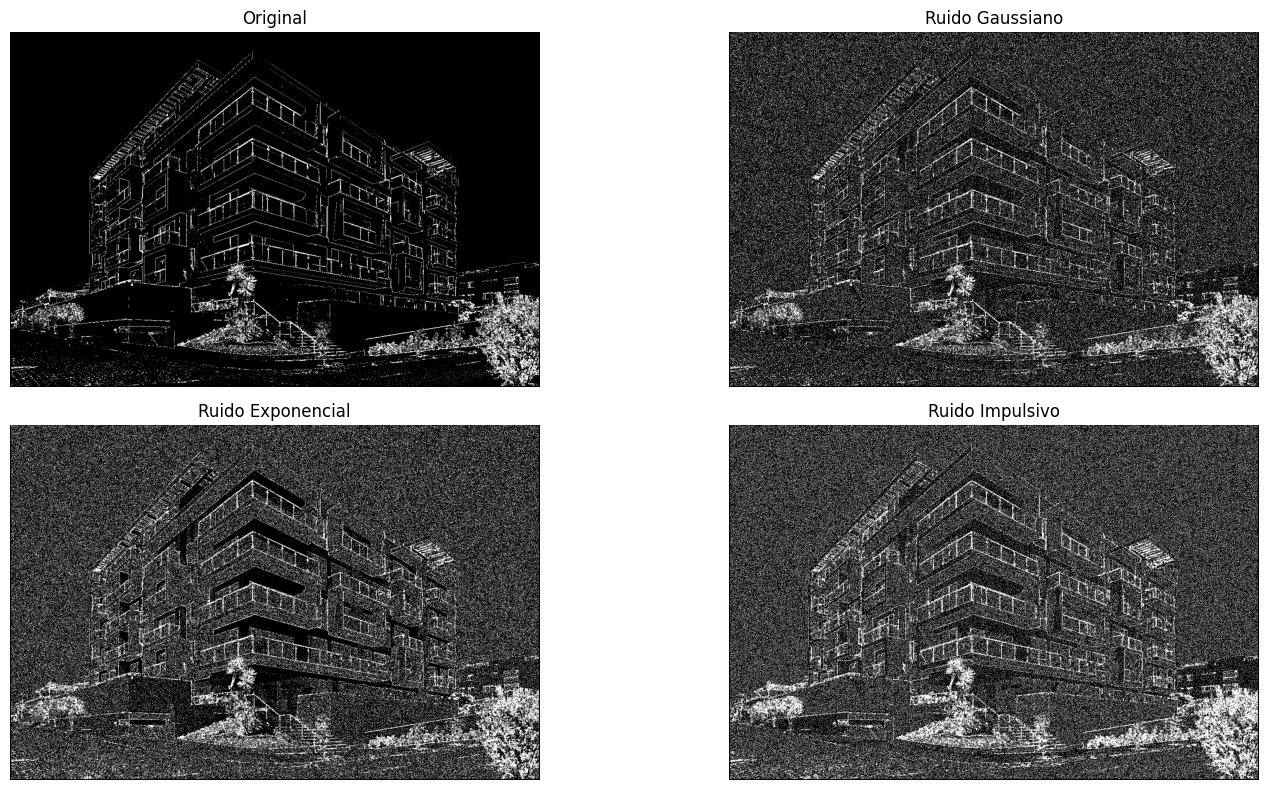

In [1048]:
# Se muestran los resultados para la imagen seleccionada y sus versiones contaminadas

def mostrar(imagenes, titulos):
    plt.figure(figsize=(16, 8))
    for i, (img, title) in enumerate(zip(imagenes, titulos), 1):
        plt.subplot(2, 2, i)
        plt.imshow(cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE))
        plt.title(title)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

mostrar([esusan_o, esusan_g, esusan_e, esusan_i],
        ["Original", "Ruido Gaussiano", "Ruido Exponencial", "Ruido Impulsivo"])

In [ ]:
# En los resultados se observa que al aplicar el método de SUSAN para esquinas en la imagen original, se detectan vértices y esquinas claras y definidas.
# Pero en las imágenes contaminadas, el ruido crea mínimos falsos que confunden al detector y muestra pseudo-esquinas, que se incrementan con el ruido 
# exponenecial e impulsivo.

### 4) Respuestas a las preguntas teóricas:

a) ¿Cuál es el objetivo del método de umbralización de Otsu?

El método de Otsu es una técnica automática de umbralización que busca separar una imagen en dos clases (fondo y objeto) maximizando la separación entre ambas. Su objetivo principal es encontrar el umbral óptimo que minimice la varianza intra-clase (dentro de cada grupo) y maximice la varianza inter-clase (entre los grupos).

Ese valor óptimo depende de la distribución de intensidades y Otsu ofrece un criterio objetivo y automático, sin intervención manual ya que calcula el histograma, evalúa todos los posibles umbrales (de 0 a 255) y elije el que mejor separa las dos clases.

b) Describa la etapa de supresión de no máximos del método de Canny. ¿Qué problema soluciona, con respecto al filtro de Sobel?

La supresión de no máximos es una etapa intermedia del detector de bordes de Canny. Su función es adelgazar los bordes detectados, para dejarlos de un píxel de grosor. 

Cuando se aplica un detector de gradiente como Sobel, se obtiene una magnitud del gradiente para cada píxel y las direcciones de borde. Su problema es que el gradiente resalta las zonas de cambio, pero el resultado es un borde grueso, de varios píxeles de ancho. Esos píxeles vecinos representan el mismo borde físico. Por ejemplo, un borde ideal debería ser una línea, pero Sobel deja una banda ancha. Entonces la supresión de no máximos filtra esa banda gruesa, y busca el máximo local de la magnitud del gradiente a lo largo de la dirección del borde, manteniendo así solo los píxeles que son máximos locales y suprime todos los demás, es decir, los lleva a cero. Así, el contorno final es una línea delgada.

c) En el contexto de Análisis y tratamiento de imágenes, ¿qué es una máscara circular?

En análisis y procesamiento de imágenes, una máscara circular es una región local con forma de círculo que se usa para definir qué píxeles vecinos considerar alrededor de un píxel central, por lo tanto, es una herramienta local para operar sobre un vecindario en forma de disco. Su objetivo es procesar la imagen de forma más simétrica y más adaptada a estructuras naturales que no son cuadradas.